# Spaceship Titanic: Logistic Regression
## Imports

In [1]:
import warnings
from pathlib import Path
from typing import cast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

In [2]:
warnings.simplefilter(action="ignore", category=FutureWarning)

## Read data

In [3]:
data_dir = Path.cwd().parent / "input" / "spaceship-titanic"
assert data_dir.exists(), f"directory doesn't exist: {data_dir}"

In [4]:
df = pd.read_csv(
    data_dir / "train_imputed.csv",
    index_col="PassengerId",
    dtype={"CompCntReduced": pd.CategoricalDtype(categories=["0", "1", "2", "3+"], ordered=True)},
).assign(CompCntReduced=lambda x: x.CompCntReduced.cat.codes)
df.head(10)

,Alone,CompCntReduced,HomePlanetOrd,CryoSleep,CabinDeckOrd,CabinPort,DestinationOrd,DiscretizedAge4,DiscretizedAge5,VIP,PosRoomService,PosFoodCourt,PosShoppingMall,PosSpa,PosVRDeck,PTTotalSpent,Transported
PassengerId,,,,,,,,,,,,,,,,,
0001_01,True,0,1,False,0,True,2,3,3,False,False,False,False,False,False,-1.140331,False
0002_01,True,0,0,False,3,False,2,1,2,False,True,True,True,True,True,0.576497,True
0003_01,False,1,1,False,5,False,2,3,4,True,True,True,False,True,True,1.501611,False
0003_02,False,1,1,False,5,False,2,2,3,False,False,True,True,True,True,1.242461,False
0004_01,True,0,0,False,3,False,2,0,0,False,True,True,True,True,True,0.704061,True
0005_01,True,0,0,False,3,True,1,3,4,False,False,True,False,True,False,0.592626,True
0006_01,False,1,0,False,3,False,2,1,2,False,True,True,True,False,False,0.828008,True
0006_02,False,1,0,True,4,False,2,2,2,False,False,False,False,False,False,-1.140331,True
0007_01,True,0,0,False,3,False,2,2,3,False,False,True,True,True,False,0.681374,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Alone            8693 non-null   bool   
 1   CompCntReduced   8693 non-null   int8   
 2   HomePlanetOrd    8693 non-null   int64  
 3   CryoSleep        8693 non-null   bool   
 4   CabinDeckOrd     8693 non-null   int64  
 5   CabinPort        8693 non-null   bool   
 6   DestinationOrd   8693 non-null   int64  
 7   DiscretizedAge4  8693 non-null   int64  
 8   DiscretizedAge5  8693 non-null   int64  
 9   VIP              8693 non-null   bool   
 10  PosRoomService   8693 non-null   bool   
 11  PosFoodCourt     8693 non-null   bool   
 12  PosShoppingMall  8693 non-null   bool   
 13  PosSpa           8693 non-null   bool   
 14  PosVRDeck        8693 non-null   bool   
 15  PTTotalSpent     8693 non-null   float64
 16  Transported      8693 non-null   bool   
dtypes: bool(10

## Categorical features: One-hot encoding
Figuring out how I'm going to do this:

In [6]:
feat = "HomePlanetOrd"
uniq_vals: list[int] = np.sort(df[feat].unique()).tolist()

In [7]:
encoder = OneHotEncoder(
    categories=[uniq_vals],  # pyright: ignore [reportArgumentType]
    sparse_output=False,
    dtype=np.int8,
)
one_hot_encoded = encoder.fit_transform(df[[feat]])

In [8]:
new_cols = [f"{feat}_{val}" for val in uniq_vals]
df_one_hot = pd.DataFrame(one_hot_encoded, columns=new_cols, index=df.index)

In [9]:
df = df.merge(df_one_hot, left_index=True, right_index=True)
df[[feat, *new_cols]].head(20)

,HomePlanetOrd,HomePlanetOrd_0,HomePlanetOrd_1,HomePlanetOrd_2
PassengerId,,,,
0001_01,1,0,1,0
0002_01,0,1,0,0
0003_01,1,0,1,0
0003_02,1,0,1,0
0004_01,0,1,0,0
0005_01,0,1,0,0
0006_01,0,1,0,0
0006_02,0,1,0,0
0007_01,0,1,0,0


In [10]:
df = df.drop(columns=feat)

Turn the above code into a function:

In [11]:
def one_hot_encode(df: pd.DataFrame, feat: str) -> pd.DataFrame:
    uniq_vals = np.sort(df[feat].unique()).tolist()

    encoder = OneHotEncoder(
        categories=[uniq_vals],  # pyright: ignore [reportArgumentType]
        sparse_output=False,
        dtype=np.int8,
    )
    df_one_hot = pd.DataFrame(
        encoder.fit_transform(df[[feat]]),
        columns=[f"{feat}_{val}" for val in uniq_vals],
        index=df.index,
    )

    df = df.merge(df_one_hot, left_index=True, right_index=True).drop(columns=feat)
    return df

In [12]:
cat_cols = [
    "CompCntReduced",
    "CabinDeckOrd",
    "DestinationOrd",
    "DiscretizedAge4",
    "DiscretizedAge5",
]
for col in cat_cols:
    df = one_hot_encode(df, col)

In [13]:
# Re-order DataFrame columns
cols = [
    "Alone",
    "CompCntReduced_0",
    "CompCntReduced_1",
    "CompCntReduced_2",
    "CompCntReduced_3",
    "HomePlanetOrd_0",
    "HomePlanetOrd_1",
    "HomePlanetOrd_2",
    "CryoSleep",
    "CabinDeckOrd_0",
    "CabinDeckOrd_1",
    "CabinDeckOrd_2",
    "CabinDeckOrd_3",
    "CabinDeckOrd_4",
    "CabinDeckOrd_5",
    "CabinPort",
    "DestinationOrd_0",
    "DestinationOrd_1",
    "DestinationOrd_2",
    "DiscretizedAge4_0",
    "DiscretizedAge4_1",
    "DiscretizedAge4_2",
    "DiscretizedAge4_3",
    "DiscretizedAge5_0",
    "DiscretizedAge5_1",
    "DiscretizedAge5_2",
    "DiscretizedAge5_3",
    "DiscretizedAge5_4",
    "VIP",
    "PosRoomService",
    "PosFoodCourt",
    "PosShoppingMall",
    "PosSpa",
    "PosVRDeck",
    "PTTotalSpent",
    "Transported",
]
df = df[cols]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Alone              8693 non-null   bool   
 1   CompCntReduced_0   8693 non-null   int8   
 2   CompCntReduced_1   8693 non-null   int8   
 3   CompCntReduced_2   8693 non-null   int8   
 4   CompCntReduced_3   8693 non-null   int8   
 5   HomePlanetOrd_0    8693 non-null   int8   
 6   HomePlanetOrd_1    8693 non-null   int8   
 7   HomePlanetOrd_2    8693 non-null   int8   
 8   CryoSleep          8693 non-null   bool   
 9   CabinDeckOrd_0     8693 non-null   int8   
 10  CabinDeckOrd_1     8693 non-null   int8   
 11  CabinDeckOrd_2     8693 non-null   int8   
 12  CabinDeckOrd_3     8693 non-null   int8   
 13  CabinDeckOrd_4     8693 non-null   int8   
 14  CabinDeckOrd_5     8693 non-null   int8   
 15  CabinPort          8693 non-null   bool   
 16  DestinationOrd_0   8

In [14]:
# Convert boolean columns
bool_cols = df.select_dtypes(include=[bool]).columns.values.tolist()  # pyright: ignore [reportArgumentType]
df.loc[:, bool_cols] = df[bool_cols].astype(np.int8)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Alone              8693 non-null   int8   
 1   CompCntReduced_0   8693 non-null   int8   
 2   CompCntReduced_1   8693 non-null   int8   
 3   CompCntReduced_2   8693 non-null   int8   
 4   CompCntReduced_3   8693 non-null   int8   
 5   HomePlanetOrd_0    8693 non-null   int8   
 6   HomePlanetOrd_1    8693 non-null   int8   
 7   HomePlanetOrd_2    8693 non-null   int8   
 8   CryoSleep          8693 non-null   int8   
 9   CabinDeckOrd_0     8693 non-null   int8   
 10  CabinDeckOrd_1     8693 non-null   int8   
 11  CabinDeckOrd_2     8693 non-null   int8   
 12  CabinDeckOrd_3     8693 non-null   int8   
 13  CabinDeckOrd_4     8693 non-null   int8   
 14  CabinDeckOrd_5     8693 non-null   int8   
 15  CabinPort          8693 non-null   int8   
 16  DestinationOrd_0   8

In [15]:
df = df.astype(np.float_)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Alone              8693 non-null   float64
 1   CompCntReduced_0   8693 non-null   float64
 2   CompCntReduced_1   8693 non-null   float64
 3   CompCntReduced_2   8693 non-null   float64
 4   CompCntReduced_3   8693 non-null   float64
 5   HomePlanetOrd_0    8693 non-null   float64
 6   HomePlanetOrd_1    8693 non-null   float64
 7   HomePlanetOrd_2    8693 non-null   float64
 8   CryoSleep          8693 non-null   float64
 9   CabinDeckOrd_0     8693 non-null   float64
 10  CabinDeckOrd_1     8693 non-null   float64
 11  CabinDeckOrd_2     8693 non-null   float64
 12  CabinDeckOrd_3     8693 non-null   float64
 13  CabinDeckOrd_4     8693 non-null   float64
 14  CabinDeckOrd_5     8693 non-null   float64
 15  CabinPort          8693 non-null   float64
 16  DestinationOrd_0   8

In [16]:
df.head(20)

,Alone,CompCntReduced_0,CompCntReduced_1,CompCntReduced_2,CompCntReduced_3,HomePlanetOrd_0,HomePlanetOrd_1,HomePlanetOrd_2,CryoSleep,CabinDeckOrd_0,...,DiscretizedAge5_3,DiscretizedAge5_4,VIP,PosRoomService,PosFoodCourt,PosShoppingMall,PosSpa,PosVRDeck,PTTotalSpent,Transported
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.140331,0.0
0002_01,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.576497,1.0
0003_01,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.501611,0.0
0003_02,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.242461,0.0
0004_01,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.704061,1.0
0005_01,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.592626,1.0
0006_01,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.828008,1.0
0006_02,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.140331,1.0
0007_01,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.681374,1.0


In [17]:
cols_to_drop = {
    "Alone",
    "DiscretizedAge4_0",
    "DiscretizedAge4_1",
    "DiscretizedAge4_2",
    "DiscretizedAge4_3",
    "VIP",
    "Transported",
}
feat_cols = [col for col in cols if col not in cols_to_drop]
feat_cols

['CompCntReduced_0',
 'CompCntReduced_1',
 'CompCntReduced_2',
 'CompCntReduced_3',
 'HomePlanetOrd_0',
 'HomePlanetOrd_1',
 'HomePlanetOrd_2',
 'CryoSleep',
 'CabinDeckOrd_0',
 'CabinDeckOrd_1',
 'CabinDeckOrd_2',
 'CabinDeckOrd_3',
 'CabinDeckOrd_4',
 'CabinDeckOrd_5',
 'CabinPort',
 'DestinationOrd_0',
 'DestinationOrd_1',
 'DestinationOrd_2',
 'DiscretizedAge5_0',
 'DiscretizedAge5_1',
 'DiscretizedAge5_2',
 'DiscretizedAge5_3',
 'DiscretizedAge5_4',
 'PosRoomService',
 'PosFoodCourt',
 'PosShoppingMall',
 'PosSpa',
 'PosVRDeck',
 'PTTotalSpent']

In [18]:
X = df[feat_cols]
y = df["Transported"]

## Dummy Classifier

In [19]:
dummy_clf = DummyClassifier(strategy="uniform", random_state=333).fit(X, y)
y_pred = dummy_clf.predict(X)

In [20]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

         0.0       0.50      0.50      0.50      4315
         1.0       0.51      0.51      0.51      4378

    accuracy                           0.50      8693
   macro avg       0.50      0.50      0.50      8693
weighted avg       0.50      0.50      0.50      8693



## Logistic Regression
### L1 Regularization
Find optimal model:

In [21]:
logistic_model = LogisticRegression(penalty="l1", random_state=33, solver="liblinear", max_iter=1000)
param_grid = {"C": np.logspace(-2, 1, 50), "class_weight": [None, "balanced"]}

In [22]:
grid_search = GridSearchCV(logistic_model, param_grid=param_grid, scoring="accuracy", n_jobs=2).fit(X, y)

In [23]:
cv_results = (
    pd.DataFrame(grid_search.cv_results_)
    .drop(columns=["mean_fit_time", "std_fit_time", "mean_score_time", "std_score_time", "params"])
    .sort_values(by="rank_test_score")
    .reset_index(drop=True)
)
cv_results.head(10)

,param_C,param_class_weight,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.040949,None,0.730305,0.739505,0.728005,0.758343,0.752589,0.741749,0.011981,1
1,0.054287,balanced,0.728580,0.741231,0.728005,0.760644,0.750288,0.741749,0.012590,1
2,0.054287,None,0.729730,0.742381,0.728005,0.760069,0.747986,0.741634,0.011902,3
3,0.062506,balanced,0.729730,0.743531,0.727430,0.760644,0.746835,0.741634,0.012129,4
4,0.047149,balanced,0.730305,0.740081,0.728005,0.758343,0.750863,0.741519,0.011669,5
5,0.062506,None,0.729730,0.745256,0.728005,0.758343,0.746260,0.741519,0.011324,6
6,0.071969,None,0.731455,0.744681,0.728005,0.759494,0.743959,0.741519,0.011162,7
7,0.082864,balanced,0.730880,0.745256,0.728580,0.757768,0.745109,0.741518,0.010691,8
8,0.047149,None,0.728580,0.741231,0.728005,0.758343,0.750863,0.741404,0.012004,9
9,0.040949,balanced,0.728580,0.738930,0.726279,0.759494,0.753165,0.741290,0.013152,10


In [24]:
grid_search.best_params_

{'C': 0.040949150623804255, 'class_weight': None}

In [25]:
best_model = grid_search.best_estimator_
best_model = cast(LogisticRegression, best_model)

Inspect model coefficients:

In [26]:
coef = best_model.coef_.flatten()
coef

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.10711777,
        0.98955743,  0.        ,  0.71413476,  0.01429178,  0.23468334,
       -0.1721253 ,  0.25202683, -0.35854225,  0.        , -0.41534589,
        0.21465601,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.01850152,  0.        , -0.29583537,  0.34488585,
        0.27850703, -0.39186316, -0.4419126 , -0.76422832])

In [27]:
# Features that have been "eliminated"
feature_names = best_model.feature_names_in_
feature_names[coef == 0].tolist()

['CompCntReduced_0',
 'CompCntReduced_1',
 'CompCntReduced_2',
 'CompCntReduced_3',
 'HomePlanetOrd_2',
 'CabinDeckOrd_5',
 'DestinationOrd_1',
 'DestinationOrd_2',
 'DiscretizedAge5_0',
 'DiscretizedAge5_1',
 'DiscretizedAge5_2',
 'DiscretizedAge5_4']

In [28]:
df_coef = (
    pd.DataFrame(data={"Feature": feature_names, "Coefficient": coef})
    .set_index("Feature")
    .assign(AbsCoef=lambda x: np.abs(x.Coefficient))
)
df_coef

,Coefficient,AbsCoef
Feature,,
CompCntReduced_0,0.000000,0.000000
CompCntReduced_1,0.000000,0.000000
CompCntReduced_2,0.000000,0.000000
CompCntReduced_3,0.000000,0.000000
HomePlanetOrd_0,-0.107118,0.107118
HomePlanetOrd_1,0.989557,0.989557
HomePlanetOrd_2,0.000000,0.000000
CryoSleep,0.714135,0.714135
CabinDeckOrd_0,0.014292,0.014292


In [29]:
df_coef = df_coef[df_coef.AbsCoef > 0].sort_values(by="AbsCoef", ascending=False)
df_coef["Color"] = np.where(df_coef.Coefficient > 0, "#228B22", "#DE0030")

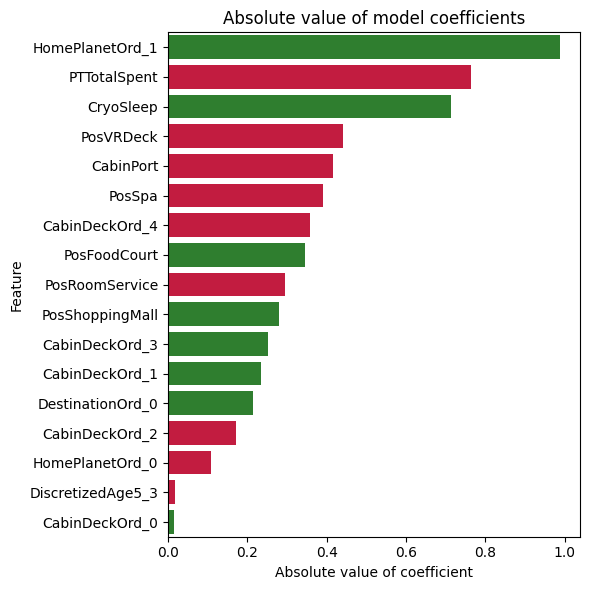

In [30]:
fig = plt.figure(figsize=(6.0, 6.0), layout="tight")
ax = fig.add_subplot()
sns.barplot(
    x=df_coef.AbsCoef,
    y=df_coef.index,
    palette=df_coef.Color.tolist(),
    orient="h",
    ax=ax,
)
ax.set_title("Absolute value of model coefficients")
ax.set_xlabel("Absolute value of coefficient")
plt.show()